In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

`root` 是训练/测试数据存储的路径
`train` 指明使用训练数据集还是测试数据集
`download=True` 如果在`root`中没有指定的数据集就从互联网上下载
`transform`和`target_transform`指明特征和标签的变换

In [7]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Iterating and Visualizing the Dataset

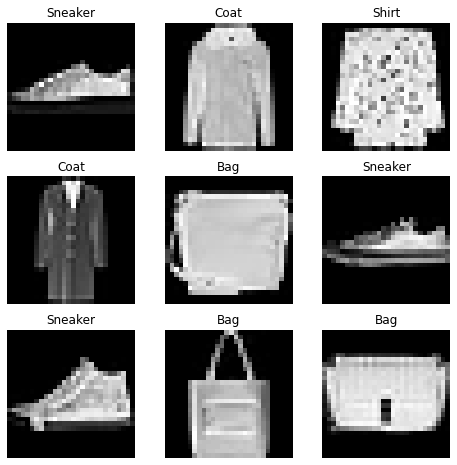

In [36]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker", 
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files
一个自定义的Dataset类必须实现三个函数：\_\_init\_\_, \_\_len\_\_和\_\_getitem\_\_。FashionMNIST的图片存储在`img_dir`目录下，他们相应的标签存储在CSV文件`annotations_file`中。

In [12]:
import os
import pandas as pd
from torchvision.io import read_image

In [32]:
class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(annotation_file)
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_img(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

\_\_getitem\_\_函数从数据集中给定的下标index`idx`加载并返回一个样本。基于这个下标，它可以识别图像的存储位置，将它用`read_image`函数转换为一个张量，并在`self.img_labels`中的csv数据检索相应的标签，对他们调用变换（transform）函数（如果适合的话），并在一个元组中返回张量图和相应的标签。

### Preparing your data for training with DataLoaders

`Dataset`一次一个样本的检索我们数据集的特征和标签。在训练模型时，我们通常希望以 "minibatch "的形式传递样本，在每个epoch打乱数据以减少模型的过拟合，并使用python的`multiprocessing`来加速数据检索。

`DataLoader`是一个可迭代的对象，它用一个简单的API为我们抽象了这种复杂性。

In [33]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the DataLoader

我们已经将该数据集加载到`DataLoader`中，并可以根据需要迭代该数据集。下面的每次迭代都会返回一批`train_features`和`train_labels`的数据（分别包括`batch_size=64`特征和标签）。因为我们指定了shuffle=True，所以在我们遍历所有批次后，数据会被打乱（要想对数据加载顺序进行更精细的控制，请看[Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)）。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


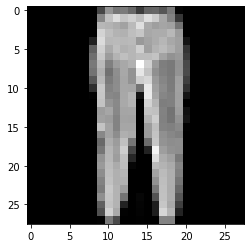

Label: 1


In [34]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")